# Load Libraries

In [ ]:
!pip install llvmlite>=0.34.0
!pip install --upgrade pynndescent
!pip install https://github.com/lmcinnes/umap/archive/0.5dev.zip
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

from pynndescent import NNDescent
import numpy as np
from IPython.display import clear_output
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set
from torchsummary import summary
from torch.utils.data import Dataset, TensorDataset, DataLoader
clear_output()

# Load Image

In [ ]:
X = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None).data
clear_output()
print(X.shape)

torch.Size([60000, 28, 28])


# Construct Graph

In [ ]:
def knn_graph_construction(dataset, n_trees, n_iters, metric, n_neighbors):
  '''
  Building the knn graph, return with indices and distances.
  Check library pynndescent.NNDescent for more details.

  Parameters
  ----------
  dataset: the dataset, it should be a two dimension numpy arrary.
       For example: (number_of_images, rest_of_the_dimensions).
  n_trees: number of trees in random projection forest.
  n_iters: max number of nearest neighbor iters to perform.
  metric: distance metric
  n_neighbors: number of neighbors for computing k-neighbor graph.

  Returns
  -------
  indices, distances
  '''

  # get nearest neighbors
  nnd = NNDescent(
      dataset.reshape((len(dataset), np.product(np.shape(dataset)[1:]))),
      n_neighbors=n_neighbors,
      metric=metric,
      n_trees=n_trees,
      n_iters=n_iters,
      max_candidates=60,
      verbose=True
  )

  # get indices and distances
  knn_indices, knn_dists = nnd.neighbor_graph

  # nearest neighbors and distances for each point in the dataset
  print('output data shapes: ', np.shape(knn_indices), np.shape(knn_dists))

  return knn_indices, knn_dists

In [ ]:
def fuzzy_simplicial_complex_construction(dataset, knn_indices, knn_dists, n_neighbors, metric, random_state):
  '''
  The fuzzy_simplicial_set function takes the nearest neighbor graph
  and computes a graph of the probabilities of an edge exists between points.
  '''
  random_state = check_random_state(None)

  # build fuzzy_simplicial_set
  umap_graph, sigmas, rhos = fuzzy_simplicial_set(
      X=dataset,
      n_neighbors=n_neighbors,
      metric=metric,
      random_state=random_state,
      knn_indices=knn_indices,
      knn_dists=knn_dists,
  )

  return umap_graph, sigmas, rhos


#Construction Dataset and DataLoder

In [ ]:
class ConnectDataset(Dataset):
  def __init__(self, edges_to_exp, edges_from_exp, batch_size):
    self.edges_to_exp = edges_to_exp
    self.edges_from_exp = edges_from_exp
    self.length = len(self.edges_to_exp)
    self.batch_size = batch_size

  def __len__(self):
    return self.length

  def __getitem__(self, i):
    #rand_index = np.random.choice(range(self.length), batch_size)
    #rand_index = torch.Tensor(rand_index).long
    indices = torch.tensor([i])
    return torch.index_select(self.edges_to_exp, 0, indices),torch.index_select(self.edges_from_exp, 0, indices)
    #return self.edges_to_exp[i], self.edges_from_exp[i]

In [ ]:
def get_graph_elements(graph_, n_epochs):
    ### should we remove redundancies () here??
    # graph_ = remove_redundant_edges(graph_)

    #original->csr_matrix
    #changed->coo_matrix ‘triplet’ format
    graph = graph_.tocoo()
    # eliminate duplicate entries by summing them together
    graph.sum_duplicates()
    #print(np.shape(graph.data))
    # number of vertices in dataset
    n_vertices = graph.shape[1]
    # get the number of epochs based on the size of the dataset
    #print(np.shape(graph.data))
    if n_epochs is None:
        # For smaller datasets we can use more epochs
        if graph.shape[0] <= 10000:
            n_epochs = 500
        else:
            n_epochs = 200
    # remove elements with very low probability
    graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
    graph.eliminate_zeros()
    # get epochs per sample based upon edge probability
    #print(np.shape(graph.data))
    epochs_per_sample = n_epochs * graph.data

    head = graph.row #graph.row -> COO COO format column index array of the matrix
    tail = graph.col #graph.col -> COO format row index array of the matrix
    weight = graph.data #graph.data -> COO format data array of the matrix

    return graph, epochs_per_sample, head, tail, weight, n_vertices

def construct_edge_dataset(umap_graph,n_epochs,batch_size):
  graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(umap_graph, n_epochs)

  edges_to_exp, edges_from_exp = (np.repeat(head, epochs_per_sample.astype("int")),np.repeat(tail, epochs_per_sample.astype("int")),)

  # shuffle edges
  shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
  edges_to_exp = edges_to_exp[shuffle_mask].astype(np.int64)
  edges_from_exp = edges_from_exp[shuffle_mask].astype(np.int64)

  edges_to_exp = torch.Tensor(edges_to_exp).long() # transform to torch tensor
  edges_from_exp = torch.Tensor(edges_from_exp).long()

  edge_dataset = ConnectDataset(edges_to_exp,edges_from_exp,batch_size)
  return edge_dataset

# Find a and b

In [ ]:
from scipy.optimize import curve_fit
def find_ab_params(spread, min_dist):
    """Fit a, b params for the differentiable curve used in lower
    dimensional fuzzy simplicial complex construction. We want the
    smooth curve (from a pre-defined family with simple gradient) that
    best matches an offset exponential decay.
    """

    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, spread * 3, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
    params, covar = curve_fit(curve, xv, yv)
    return params[0], params[1]

# Build Model

In [ ]:
class EncoderNet(nn.Module):
    def __init__(self, n_components=2):
        super(EncoderNet,self).__init__()
        self.n_components = n_components
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=(2,2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(2,2), padding=(1, 1)),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(6272,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,self.n_components)
            
        )
    def forward(self,input):
        out = self.net(input)
        out = self.classifier(out)
        return out

# Build Loss Function

In [ ]:
class parametricUMAP_loss(nn.Module):
  def __init__(
      self,
      batch_size,
      negative_sample_rate,
      _a,
      _b,
      device,
      repulsion_strength=1.0,
      ):
    super(parametricUMAP_loss, self).__init__()
    self.batch_size = batch_size
    self.negative_sample_rate = negative_sample_rate
    self._a = _a
    self._b = _b
    self.repulsion_strength = repulsion_strength
    self.device = device

  def convert_distance_to_probability(self, distances):
      return 1.0 / (1.0 + self._a * distances ** (2 * self._b))

  def compute_cross_entropy(self, probabilities_graph, probabilities_distance, EPS=1e-4):
    attraction_term = -probabilities_graph * torch.log(torch.clamp(probabilities_distance, min=EPS, max=1.0))
    repellant_term = (
        -(1.0 - probabilities_graph)
        * torch.log(torch.clamp(1.0 - probabilities_distance, min=EPS, max=1.0))
        * self.repulsion_strength
    )
    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

  #loss = umap_loss_fn(placeholder_y = [sample_edge_to_x, sample_edge_from_x], embed_to_from = y_pred)
  #staticmethod
  def forward(self, embed_to_from):
    #ctx.save_for_backward(placeholder_y, embed_to_from)

    embedding_to, embedding_from = torch.chunk(embed_to_from, 2, 1)

    embedding_neg_to = torch.repeat_interleave(embedding_to, self.negative_sample_rate, dim=0)
    repeat_neg = torch.repeat_interleave(embedding_from, self.negative_sample_rate, dim=0)

    repeat_neg_idx = torch.range(0,repeat_neg.shape[0]-1)
    idx = torch.randperm(repeat_neg_idx.shape[0])
    repeat_neg_idx = repeat_neg_idx[idx].view(repeat_neg_idx.size()).long()
    embedding_neg_from = repeat_neg[repeat_neg_idx]

    distance_embedding = torch.cat(
        ((torch.norm(embedding_to - embedding_from, dim=1)),torch.norm(embedding_neg_to - embedding_neg_from, dim=1))
        ,0)

    # convert probabilities to distances
    probabilities_distance = self.convert_distance_to_probability(distance_embedding)

    # set true probabilities based on negative sampling
    probabilities_graph = torch.cat(
        (torch.ones(self.batch_size),
         torch.zeros(self.batch_size * self.negative_sample_rate)), 0).to(self.device,non_blocking=True)
    
    (attraction_loss, repellant_loss, ce_loss) = self.compute_cross_entropy(
        probabilities_graph,
        probabilities_distance,
    )
    return torch.mean(ce_loss)

# Start Training

In [ ]:
knn_indices, knn_dists = knn_graph_construction(
    dataset=X,
    n_trees=5 + int(round((X.shape[0]) ** 0.5 / 20.0)),
    n_iters=max(5, int(round(np.log2(X.shape[0])))),
    metric="euclidean",
    n_neighbors=15
    )

# build fuzzy_simplicial_set
random_state = check_random_state(None)
umap_graph, sigmas, rhos = fuzzy_simplicial_complex_construction(
    dataset=X,
    knn_indices=knn_indices,
    knn_dists=knn_dists,
    n_neighbors=15,
    metric="euclidean",
    random_state=random_state
)

# n_epochs isused to compute epochs_per_sample, which, in non-parametric UMAP, 
# is the total number of epochs to optimize embeddings over. The computed value 
# epochs_per_sample, is the number of epochs  each edge is optimized over 
# (higher probability = more epochs).

# epochs_per_sample
'''
the goal is to sample edges proportionally to the weights v_ij.
In practice this is done by by drawing and edge every t epochs, 
  where t is chosen according the the relative proportion of v_ij.
This is the epochs_per_sample vector,
  telling you how many epochs between each sampling of a given edge.
The epoch_of_next_sample simply keeps track of when to next sample each edge (in the obvious way).
Finally epochs_per_negative_sample plays a similar role for the negative sampling.

All of this is really just an optimization trick
  -- it goes a little faster doing it this way (since are already doing the negative sampling,
  so we are in a sampling style regime)than the more obvious approach.
I'm still working to find ways to make the more obvious thing "fast enough" and hope to eventually switch away,
  as the sampling is not ideal,
  for exactly the reason you ask this question: it is not obvious to a reader of the code what is going on.

'''
n_epochs = 200 

batch_size = 1000 # iterate over batches of 1000 edges
# get tensorflow dataset of edges 

edge_dataset = construct_edge_dataset(umap_graph,n_epochs,batch_size)

min_dist = 0.15 # controls how tightly UMAP is allowed to pack points together (0 is more)
_a, _b = find_ab_params(1.0, min_dist)
negative_sample_rate = 5

edge_dataloder = DataLoader(dataset=edge_dataset,batch_size=edge_dataset.batch_size,num_workers=4,shuffle=True,drop_last=True)
edge_data_iterator = iter(edge_dataloder)

if torch.cuda.is_available():
    print('使用GPU')
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True

encoder = EncoderNet()
encoder = encoder.to(device,non_blocking=True)

#test the encoder
x = torch.randn(6000,1,28,28).to(device)
encoder(x).shape

optimizer = torch.optim.Adam(encoder.parameters(),lr=1e-4, eps=1e-07, weight_decay=0, amsgrad=False)
torch_loss = parametricUMAP_loss(batch_size,negative_sample_rate,_a,_b,device)

for step in range(100000):
  try:
    sample_edge_to_x, sample_edge_from_x  = edge_data_iterator.next()
    sample_edge_to_x = torch.index_select(X, 0, sample_edge_to_x.squeeze(dim=1)).unsqueeze(1).float()
    sample_edge_from_x = torch.index_select(X, 0, sample_edge_from_x.squeeze(dim=1)).unsqueeze(1).float()
    sample_edge_to_x, sample_edge_from_x = sample_edge_to_x.cuda(), sample_edge_from_x.cuda()

    optimizer.zero_grad()

    y_pred = torch.cat((encoder(sample_edge_to_x),encoder(sample_edge_from_x)),1)
    loss = torch_loss(y_pred)
    loss.backward()
    optimizer.step()
    if step % 2000 == 0:
      print(step,loss)
  except StopIteration:
    data_iter = iter(data_loader)
    edge_data_iterator = iter(edge_dataloder)


# Visulization Result

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Text(0.5, 1.0, 'UMAP embeddings')

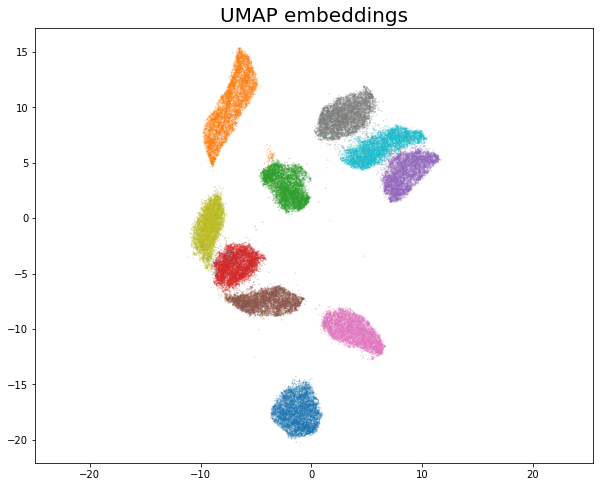

In [ ]:
# Project data
z = encoder(X.unsqueeze(1).float().cuda()).cpu()
z = z.detach().numpy()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None).train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP embeddings", fontsize=20)